In [94]:
import bt
import pandas as pd
import tradingeconomics as te
import numpy as np
from pykalman import KalmanFilter
from bokeh.models import HoverTool, ColumnDataSource, BoxZoomTool
from bokeh.models.layouts import Column
from bokeh.models.ranges import Range1d
from bokeh.models.axes import LinearAxis
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from datetime import datetime as dt
from pykalman import KalmanFilter
output_notebook()

%matplotlib inline
te.login('75420451870E4F9:7C9E487641174F6')
pd.set_option("display.max_rows",5000)

Loading BokehJS ...

In [95]:
def load_data(ticker, start = '2016-08-01', end = None, api=True):
    
    if api == False:
        data = pd.read_csv('C:\\Users\\utilizador\\PycharmProjects\\tss\\{}.csv'.format(ticker.replace(':','-')),
                               parse_dates=True, index_col=0)
        #if start is not None:
         #   data = data[data.index > start]
        #if start is not None:
         #   data = data[data.index < end]    
        
    else:
        try:
            data = te.fetchMarkets(ticker, initDate=start, endDate=end)[::-1]      
           
            #df = df.drop('Symbol', axis=1)
            #df.index = df['Date']
            #df = df.drop('Date', axis=1)
            #print(df.head())
            #data = pd.DataFrame(df['close'].values, index=pd.to_datetime(df['Date'].values), columns=[ticker])
           
        except Exception as e:
            print(e,ticker)
  
    return data

In [96]:
## load data

#tickers = ['btcusd:cur','ethusd:cur','ltcusd:cur']
tickers = ['btcusd:cur']

dataset = {}

for ticker in tickers:
    dataset[ticker] = load_data(ticker)
    
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = dataset[ticker].close.values[0],
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)

    state_means,_ = kf.filter(dataset[ticker].close.values)
    state_means = state_means.flatten()
    dataset[ticker]['fclose'] = state_means
    dataset[ticker].to_csv("{}.csv".format(ticker.split(':')[0]), header=False)
    print(dataset[ticker].head())

                symbol    open    high     low   close      fclose
2016-08-01  BTCUSD:CUR  622.50  630.00  603.63  606.35  606.350000
2016-08-02  BTCUSD:CUR  606.84  613.03  465.28  540.03  583.950530
2016-08-03  BTCUSD:CUR  540.00  572.34  521.00  563.42  578.653207
2016-08-04  BTCUSD:CUR  563.99  583.97  552.00  576.13  578.119877
2016-08-05  BTCUSD:CUR  578.14  578.20  562.00  572.50  577.101290


In [97]:
def to_bt(data):      
    data.index.name = 'Date'
    data.columns = [ticker]
    data = data.iloc[::-1]
    return data

ticker ='btcusd:cur' 
data = dataset[ticker]

In [98]:
tools = ['reset', 'box_select', 'pan', 'zoom_out', 'wheel_zoom']
p1 = figure(tools=tools, x_axis_type="datetime", title=ticker, plot_width=1000)
p1.line(data.index.values, data['fclose'], color='green', legend='Kalman')
p1.line(data.index.values, data['close'], color='red', legend='Price')
show(p1)

In [99]:
period = 7
rolling_min = pd.DataFrame(data.close.values).rolling(period).min().fillna(method='bfill')
rolling_max = pd.DataFrame(data.close.values).rolling(period).max().fillna(method='bfill')
sma_fast = pd.DataFrame(data.close.values).ewm(11).mean().fillna(method='bfill')
sma_slow = pd.DataFrame(data.close.values).ewm(27).mean().fillna(method='bfill')

sample = pd.concat([pd.DataFrame(data.fclose.values),pd.DataFrame(data.close.values),rolling_min,rolling_max, sma_fast, sma_slow],axis=1)
sample.index = data.index
sample.columns = ['FPrice','Price', 'Min','Max','FSMA','SSMA']
#sample = sample
stoch_osc = (sample.Price - sample.Min) / (sample.Max - sample.Min) * 100


In [100]:
      
tools = ['reset', 'box_select', 'pan','xzoom_out', 'yzoom_out', 'xwheel_zoom', 'ywheel_zoom','xbox_zoom', 'ybox_zoom']
source = ColumnDataSource(data=dict(x=stoch_osc.index, y1=stoch_osc.values, y2=sample.FPrice.values, y3=sample.Price.values, y4=sample.FSMA.values, y5=sample.SSMA.values))
p2 = figure(output_backend="webgl", tools=tools, plot_width=900, x_axis_type="datetime", title=ticker)
p2.line('x', 'y1', color='green', legend='Stoch Osc', source=source)
p2.circle('x', 'y1', fill_color='green', legend='Stoch Osc', source=source)
p2.line(stoch_osc.index, 80, color='red', legend='Overbought')
p2.line(stoch_osc.index, 20, color='blue', legend='Oversold')
plots = [p2]  
    
p3 = figure(output_backend="webgl", tools=tools, x_axis_type="datetime", title=ticker, plot_width=900)
p3.line('x', 'y2', color='green', source=source, legend='Kalman')
p3.circle('x', 'y2', fill_color='white', source=source, legend='Kalman')
p3.line('x', 'y3', color='blue', source=source, legend='Price')
p3.circle('x', 'y3', fill_color='blue', source=source, legend='Price')
p3.line('x', 'y4', color='yellow', source=source, legend='FSMA')

p3.line('x', 'y5', color='black', source=source, legend='SSMA')

plots.append(p3)
p = Column(children=plots)
show(p)

C:\ProgramData\Anaconda3\lib\site-packages\bokeh\plotting\helpers.py:551: UserWarning: BoxZoomTool,WheelZoomTool,ZoomOutTool are being repeated
  warnings.warn("%s are being repeated" % ",".join(repeated_tools))


In [101]:

class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.
    Args:
        * target_weights (DataFrame): DataFrame containing the target weights   
    """
    def __init__(self, target_weights, price):
        self.price = price
        self.tw = target_weights
        self.previous_weight = 0.0
        self.previous_high = self.price[0]
        self.previous_low = self.price[0]

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]
            w = w.dropna()
            
            # print(self.tw.ix[target.now])
            # w = pd.DataFrame(w)
            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            #print("previous: {}, w: {}".format(self.previous_weight,w.values))
            if w.values == 0.0:
                w[0] = self.previous_weight                 
                
            if self.previous_weight == 1.0:            
                ## Only one position at each time
                if w.values == -1.0:                    
                    w = pd.Series([1.0])
                ## if current price > high update high
                if self.previous_high < self.price[target.now]:                    
                    self.previous_high = self.price[target.now]                  
                else:                        
                    ret = (self.price[target.now] - self.previous_high) / self.previous_high                    
                    if ret < -0.05:  
                        #print(target.now, ret, self.price[target.now])                        
                        w[0] = 0.0
                    
            elif self.previous_weight == -1.0:
                if w.values == 1.0:
                    w = pd.Series([-1.0])
                if self.previous_low > self.price[target.now]:
                    self.previous_low = self.price[target.now]
                else:                        
                    ret = (self.price[target.now] - self.previous_low) / self.previous_low
                    
                    if ret > 0.05:                        
                        w[0] = 0.0
                        
            elif self.previous_weight == 0.0:
                self.previous_low = self.price[target.now]
                self.previous_high = self.price[target.now]
                
            target.temp['weights'] = w
            self.previous_weight = target.temp['weights'].values
           
            #print("previous: {}, w: {}".format(self.previous_weight,w.values))
        # return True because we want to keep on moving down the stack
        return True
    


In [102]:
def osc(ticker, start = None, end = None,  period = 21, name='osc'):
  
    X = pd.DataFrame(sample.Price)
    X.index.name = 'Date'
    X.columns = [ticker]
  
    #plot = bt.merge(X, sample.FPrice).plot(figsize=(15, 5))
        
    # target weights
    sample['stoch_osc'] = stoch_osc.values
    tw = X.copy()
   
    sample['tw'] = 0.0  
    sample['tw'][(sample.stoch_osc < 20) & (sample.FSMA > sample.SSMA)] = 1.0  
    sample['tw'][(sample.stoch_osc > 80) & (sample.FSMA < sample.SSMA)] = -1.0 
    
    tw[ticker] = sample['tw'].values   
    
    tw.index.name = 'Date'
    tw.plot(figsize=(15, 5))
    tw.to_csv('tw.csv') 
    #for i in range(0,len(tw)):
    #    if tw[ticker].iloc[i] == 1.0:
    #        break
    #    elif tw[ticker].iloc[i] == -1.0:
    #        tw[ticker][i] = 0.0
   
    s = bt.Strategy(name, [WeighTarget(tw,X[ticker]), bt.algos.Rebalance()])
    return bt.Backtest(s, X)

osc


Exception: Cannot allocate capital to 0 because price is 0 as of 2016-08-20 00:00:00

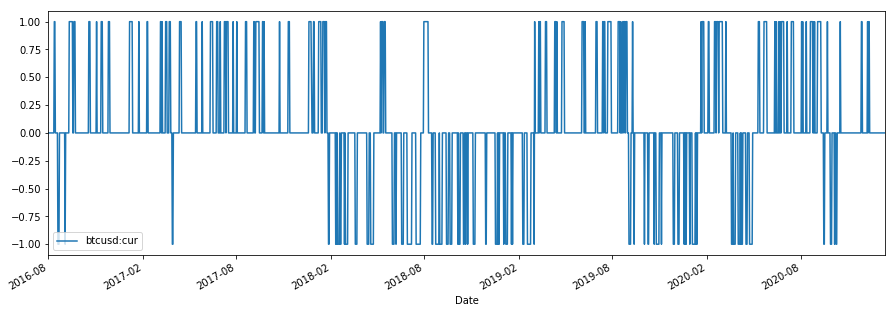

In [103]:

res = bt.run(osc(ticker,name ='osc'))

equity = res._get_series(None)

res.plot()

In [ ]:
res.display()


In [ ]:
trades = res.get_transactions(strategy_name='osc')


close_index = []
returns = []
asset_returns = []
trade_duration = []
for i in range(1, len(trades)):    
    if i % 2 != 0:
        trade_duration.append((trades.index[i][0] - trades.index[i-1][0]).total_seconds())
        if trades.quantity[i-1] < 0:
            returns.append(-((trades.price[i] - trades.price[i-1]) / trades.price[i-1]))
        else:
            returns.append((trades.price[i] - trades.price[i-1]) / trades.price[i-1])
        asset_returns.append((trades.price[i] - trades.price[i-1]) / trades.price[i-1])
        close_index.append(trades.index[i][0])
trade_returns = pd.DataFrame(returns, index = pd.to_datetime(close_index))       
asset_returns = pd.DataFrame(asset_returns, index = pd.to_datetime(close_index))   
#trades = np.sign(trades.unstack()['quantity'])

trades = res.get_security_weights()
trades = np.sign(trades)[ticker]
trades = trades.loc[trades.ne(trades.shift())]


close_trades = trades[trades==0].dropna()[1:]
long_trades = trades[trades>0].dropna()
short_trades = trades[trades<0].dropna()
#print(long_trades.index)
#print(short_trades.index)
print(sample.Price.loc[long_trades.index & sample.index])
#import bqplot.pyplot as plt
#data = load_data('EURGBP',start='2018-12-1', end='2018-12-10', remote=True)
#sns.lmplot(data=data['EURGBP'])
#plt.plot(data.index, data['EURGBP'], label="Strike", alpha=0.4)
#plt.plot(long_trades.index,data.loc[long_trades.index & data.index], marker='triangle-up' ,label="Strike", alpha=0.4)
#plt.plot(short_trades.index,data.loc[short_trades.index & data.index],marker='triangle-down', label="Strike", alpha=0.4)
#plt.show()

source = ColumnDataSource(data=dict(x1=sample.index, x2=long_trades.index, x3=short_trades.index, x4=trade_returns.index,
                                    y1=sample.Price, y2=sample.Price.loc[long_trades.index & sample.index], y3=sample.Price.loc[short_trades.index & data.index],
                                   y4=sample.Price.loc[trade_returns.index & sample.index], y5=trade_returns.values.flatten(), y6=sample.FPrice))

p1 = figure(tools=tools, x_axis_type="datetime", title=ticker, plot_width=1000)
p1.circle('x1', 'y6', color='black', legend='kalman', source=source)
p1.line('x1', 'y1', color='blue', legend='price', source=source)
#p1.circle('x1', 'y1', color='blue', size=5, legend='price', source=source)
#p1.triangle('x2','y2', color='green', size=10, legend='OPEN-BUY', source=source)
#p1.inverted_triangle('x3','y3', color='blue', size=10, legend='OPEN-SELL', source=source)
#p1.square('x4','y4', color='red', size=10, legend='CLOSE', source=source)

plots = [p1]

p2 = figure(tools=tools, x_axis_type="datetime", title='Equity', plot_width=1000)
#p2.line(equity.index, equity.osc.values, color='blue', legend='Equity')
#p2.circle(equity.index, equity.osc.values, color='blue', size=10)
p2.line('x4', 'y5', color='blue', legend='Returns', source=source)
p2.circle('x4', 'y5', color='blue', size=10, source=source)
plots.append(p2)
p = Column(children=plots)
show(p)



In [ ]:
trades = res.get_security_weights()
trades = np.sign(trades)[ticker]
trades = trades.loc[trades.ne(trades.shift())]

close_trades = trades[trades==0].dropna()[1:]
long_trades = trades[trades>0].dropna()
short_trades = trades[trades<0].dropna()

#sample.index = pd.to_datetime(sample.index)
#print(type(sample.index),type(close_trades.index))
#print(sample.index)
#print(long_trades.index)
#print(close_trades)
#print(sample.Price.loc[close_trades.index & sample.index])
#import bqplot.pyplot as plt
#data = load_data('EURGBP',start='2018-12-1', end='2018-12-10', remote=True)
#sns.lmplot(data=data['EURGBP'])
#plt.plot(data.index, data['EURGBP'], label="Strike", alpha=0.4)
#plt.plot(long_trades.index,data.loc[long_trades.index & data.index], marker='triangle-up' ,label="Strike", alpha=0.4)
#plt.plot(short_trades.index,data.loc[short_trades.index & data.index],marker='triangle-down', label="Strike", alpha=0.4)
#plt.show()

long_trades = pd.DataFrame(sample.Price.loc[long_trades.index & sample.index], index=long_trades.index)
long_trades.columns = ['Long']
short_trades = pd.DataFrame(sample.Price.loc[short_trades.index & sample.index], index=short_trades.index)
short_trades.columns = ['Short']
close_trades = pd.DataFrame(sample.Price.loc[close_trades.index & sample.index], index=close_trades.index)
close_trades.columns = ['Close']

sample = pd.concat([sample, long_trades, close_trades, short_trades])


In [ ]:

source = ColumnDataSource(data=dict(x1=sample.index,
                                    y1=sample.Price, y2=sample.Long, y3=sample.Short,y4=sample.Close, y5=sample.FPrice, y6=sample.FSMA, y7=sample.SSMA))

p1 = figure(tools=tools, x_axis_type="datetime", title=ticker, plot_width=1000)
p1.circle('x1', 'y5', color='black', legend='kalman', source=source)
p1.line('x1', 'y1', color='black', legend='price', source=source)
p1.line('x1', 'y6', color='yellow', legend='FSMA', source=source)
p1.line('x1', 'y7', color='brown', legend='SSMA', source=source)
p1.circle('x1', 'y1', color='blue', size=5, legend='price', source=source)
p1.triangle('x1','y2', color='green', size=10, legend='OPEN-BUY', source=source)
p1.inverted_triangle('x1','y3', color='blue', size=10, legend='OPEN-SELL', source=source)
p1.square('x1','y4', color='red', size=10, legend='CLOSE', source=source)


plots = [p1]

#p2 = figure(tools=tools, x_axis_type="datetime", title='Equity', plot_width=1000)
#p2.line(equity.index, equity.osc.values, color='blue', legend='Equity')
#p2.circle(equity.index, equity.osc.values, color='blue', size=10)
#p2.line('x4', 'y5', color='blue', legend='Returns', source=source)
#p2.circle('x4', 'y5', color='blue', size=10, source=source)
#plots.append(p2)
p = Column(children=plots)
show(p)
